In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' # to print multiple outputs from the same cell
import math
import utils
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import seaborn as sns
from operator import index
from collections import defaultdict
from scipy.stats import pearsonr
from datetime import datetime, timedelta
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score
import clustering_utils
from itertools import combinations

In [2]:
def get_element_cluster(element, clusters):
    for (index, list_of_elements) in enumerate(clusters):
        if element in list_of_elements:
            return index

def plot_clusters_compositions(users_df, clusters, plot_title = None):
    labels = [
        get_element_cluster(index, clusters)
        for index in range(len(users_df))
    ]

    bot_xt_pct = pd.crosstab(labels, users_df['bot'])
    bot_xt_pct.plot(
        kind='bar', 
        stacked=False, 
        log=True,
        title=plot_title,
        ylabel="Number of users"
    )
    
def visualize_clusters_entropy(clusters_ids: list, clusters_entropy: list, plot_title = None):
    """
    Plots the entropy of the clusters
    
    :param clusters_ids: list of int, the ids of the clusters to study
    :param clusters_entropy: list of float, the value of entropy for each cluster; i.e. the i-th element of this list
        contains the entropy of the i-th cluster
    """
    x = np.arange(len(clusters_ids))
    
    fig, ax = plt.subplots()
    plt.bar(x=x, height=clusters_entropy)
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Entropy')
    ax.set_title(plot_title)
    ax.set_xticks(x, clusters_ids)
    
    plt.show()
    
def apply_correlation_threshold(df: pd.DataFrame, correlation_method: str, threshold: float) -> pd.DataFrame:
    # Create correlation matrix
    corr_matrix = df.corr(numeric_only=True).abs()

    # Select upper triangle of correlation matrix (correlation matrix is symmetrical)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    return df.drop(to_drop, axis=1)

def plot_clusters_sizes(clusters, plot_title=None):
    _, ax = plt.subplots()
    
    ax.set_title(plot_title)
    ax.set_ylabel("Number of users")
    
    clusters_id = []
    clusters_size = []
    for cluster_id, cluster_elements in enumerate(clusters):
        clusters_id.append(cluster_id)
        clusters_size.append(len(cluster_elements))
    
    ax.bar(x=clusters_id, height=clusters_size, log=True)
    
compute_entropy = lambda p: -(p*math.log(p) + (1-p)*math.log(1-p)) if p != 1 and p != 0 else 0

def get_element_cluster(element, clusters):
    for (index, list_of_elements) in enumerate(clusters):
        if element in list_of_elements:
            return index

def compute_clusters_composition(users_df, clusters):
    clusters_composition = []
    for cluster_id, cluster_indexes in enumerate(clusters):
        real_users = []
        bot_users = []
        for user_index in cluster_indexes:
            if users_df.iloc[user_index]["bot"] == 1:
                bot_users.append(user_index)
            else:
                real_users.append(user_index)
        clusters_composition.append((real_users, bot_users))
    return clusters_composition

In [3]:
users_df = pd.read_csv("dataset/users_df_dataset_cleaned_with_indicators.csv")
users_df.info(verbose=True)
users_df.describe()

# dropping non numeric columns 
users_df.drop(columns=["name", "lang", "created_at", "day_with_most_tweets"], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   user_id                                   11109 non-null  int64  
 1   name                                      11108 non-null  object 
 2   lang                                      11109 non-null  object 
 3   bot                                       11109 non-null  int64  
 4   created_at                                11109 non-null  object 
 5   statuses_count                            11109 non-null  int64  
 6   account_age_in_days                       11109 non-null  int64  
 7   number_of_tweets                          11109 non-null  int64  
 8   account_average_tweets_per_day            11109 non-null  float64
 9   avg_tweets_per_actual_day                 11109 non-null  float64
 10  day_with_most_tweets              

,user_id,bot,statuses_count,account_age_in_days,number_of_tweets,account_average_tweets_per_day,avg_tweets_per_actual_day,max_number_of_tweets_in_a_day,entropy_for_day,entropy_for_hour,...,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio,tweet_num_replies_ratio,entropy_original_text,entropy_text,mean_inactive_period_length_in_seconds,median_inactive_period_length_in_seconds,mode_inactive_period_length_in_seconds,mode_count
count,1.110900e+04,11109.000000,11109.000000,11109.000000,11109.000000,11109.000000,11109.000000,11109.000000,11109.000000,11109.000000,...,1.110900e+04,11109.000000,11109.000000,11109.000000,11109.000000,1.110900e+04,1.110900e+04,1.110900e+04,1.110900e+04,11109.000000
mean,1.263638e+09,0.550545,486.128364,1827.599874,941.636241,0.262958,13.376648,52.172383,2.795355,1.995941,...,5.264295e+05,19.514334,17.394735,4.133898,7.732036,4.480553e-06,6.240292e+05,3.191962e+05,1.656887e+05,75.159600
std,9.362909e+08,0.497461,1240.441286,555.089451,1199.366972,0.680883,37.977049,87.943561,1.460038,1.086827,...,2.931097e+06,80.962879,46.416587,29.053336,2.656718,1.077466e-05,3.884880e+06,3.609929e+06,3.235014e+06,119.633439
min,6.780330e+05,0.000000,0.000000,891.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.439497,1.321162e-07,4.300000e+01,0.000000e+00,0.000000e+00,1.000000
25%,4.662898e+08,0.000000,41.000000,1312.000000,67.000000,0.022472,1.846154,6.000000,1.426345,1.032784,...,3.000000e+00,0.001644,0.957981,0.000000,6.058814,2.710693e-07,5.757338e+04,2.400000e+01,0.000000e+00,5.000000
50%,1.127892e+09,1.000000,68.000000,1702.000000,132.000000,0.035088,4.777778,18.000000,2.921107,2.234517,...,7.700000e+01,0.040902,7.500000,0.000000,6.886985,7.782775e-07,1.116038e+05,8.410000e+02,0.000000e+00,11.000000
75%,2.356956e+09,1.000000,81.000000,2080.000000,1703.000000,0.058267,8.058511,75.000000,3.710199,2.789275,...,6.473700e+04,20.000000,20.800000,0.000000,10.493086,1.498476e-06,2.841108e+05,5.100100e+04,0.000000e+00,128.000000
max,3.164942e+09,1.000000,7226.000000,3901.000000,3668.000000,6.792821,1759.500000,2131.000000,5.706424,5.705947,...,9.638758e+07,3519.000000,2877.000000,1762.000000,11.684289,6.034723e-05,1.182533e+08,1.182533e+08,1.182533e+08,2634.000000


## Clustering Preprocessing - Feature Selection
In order to avoid the curse of dimensionality, one needs to reduce the number of features.
It is also considered good practice to remove features that have a high correlation, so that you are not weighting a certain behaviour more than any other.  

<Figure size 1600x600 with 0 Axes>

<AxesSubplot: >

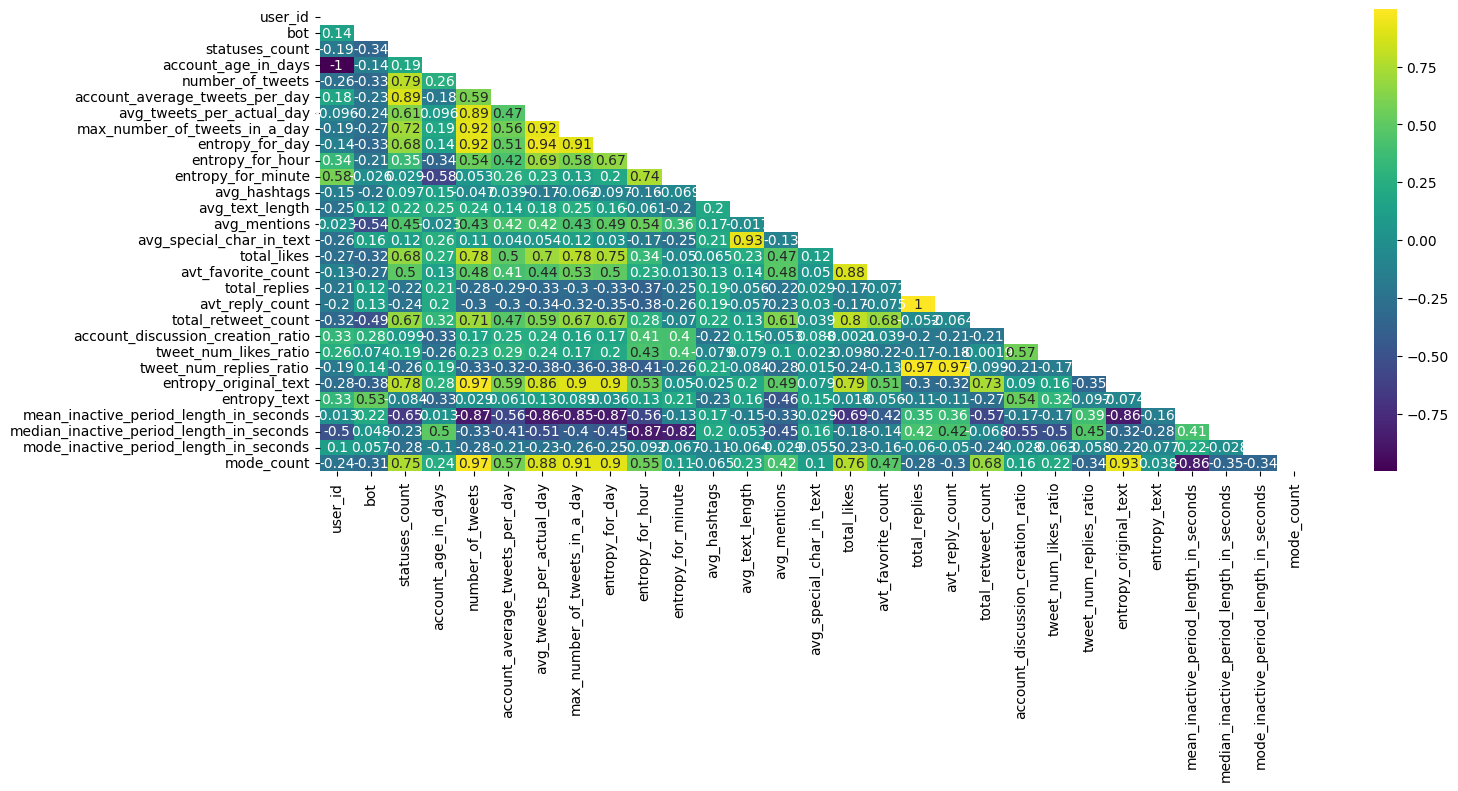

In [4]:
correlation_method = "spearman"
dfCorr = users_df.corr(method= correlation_method, numeric_only=True)
plt.figure(figsize=(16,6))
sns.heatmap(dfCorr, annot=True, cmap="viridis",mask=np.triu(dfCorr))
plt.show()

Finding and dropping all columns above a high correlation threshold of 0.7.

In [5]:
correlation_treshold = 0.7
subset_df = apply_correlation_threshold(users_df, correlation_method, correlation_treshold)
subset_df.drop(columns=["user_id", "bot"], inplace=True)

In [6]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11109 entries, 0 to 11108
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   statuses_count                          11109 non-null  int64  
 1   number_of_tweets                        11109 non-null  int64  
 2   avg_tweets_per_actual_day               11109 non-null  float64
 3   avg_hashtags                            11109 non-null  float64
 4   avg_text_length                         11109 non-null  float64
 5   avg_mentions                            11109 non-null  float64
 6   total_likes                             11109 non-null  int64  
 7   avt_favorite_count                      11109 non-null  float64
 8   total_replies                           11109 non-null  int64  
 9   total_retweet_count                     11109 non-null  int64  
 10  account_discussion_creation_ratio       11109 non-null  fl

# DBSCAN
A density based type of clustering method.

## The Algorithm in a Nutshell

* A point is a **core** if it has more than minPts points within eps
* A point is a **border** if it has less than minPts points within eps but one of its neighboors is a core point
* A **noise** point is neither a core or a border point


1. Label all points as core, border or noise points
1. Eliminate noise points.
1. Put an edge between all core points that are within eps of each other
1. Make each group of connected core points into a separate cluster.
1. Assign each border point to one of the clusters of its associated core points.

> Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996, August). A density-based algorithm for discovering clusters in large spatial databases with noise. In Kdd (Vol. 96, No. 34, pp. 226-231).

Running [example](http://matlaspisa.isti.cnr.it:5055/Dbscan)  
Wikipedia [link](https://en.wikipedia.org/wiki/DBSCAN)

## DBSCAN Problems

* Parameter tuning
* Does not recognize different densities

## Improvements to DBSCAN
DMDBSCAN is an improved form of DBSCAN where we can automatically tune the radius of the neigbourhood, the eps, automatically based on the different densities within the population. We use the k-distance plot for this.
* By exploiting the expectation of increased number of points when increasing the radious(eps) around a given point, you can create a ratio between points that better recognizes different densities, as well as noise within the dataset.
* This expectation produces a number for the optimal value of eps based on density and distance to neighbouring points.

## Clustering Preprocessing - Normalization  
A good practice in clustering is to avoid the bias given by the range of the different attributes. We achieve this through normalization.  
The most common adopted normalizations are: Z-Score and Min-Max, we will employ Z-score, as it keeps min/max values as well as normalising in terms of standard deviation and variance.

https://www.researchgate.net/post/If-I-cluster-with-min-max-normalization-I-get-different-results-than-if-I-cluster-with-Z-score-normalization-how-should-I-proceed


In [7]:
scaler = StandardScaler()
scaler.fit(subset_df.values)
scaler.transform(subset_df.values)
scaler.inverse_transform(scaler.transform(subset_df.values))
transform_result = scaler.fit_transform(subset_df.values)

StandardScaler()

array([[-0.3306459 , -0.68008622, -0.22935888, ..., -0.14229293,
        -0.26573769, -0.13234402],
       [-0.34838232, -0.68842433, -0.23006109, ..., -0.14229293,
        -0.29303514, -0.13049436],
       [-0.38949857, -0.78181113, -0.29957988, ..., -0.14229293,
        -0.39702312,  2.10903074],
       ...,
       [-0.38707997, -0.78014351, -0.31274632, ..., -0.14229293,
        -0.40245112,  3.41425607],
       [-0.35805673, -0.70259911, -0.23889977, ..., -0.14229293,
        -0.29238634, -0.12836481],
       [ 3.86401793,  2.09733721,  1.19068249, ..., -0.14229293,
        -0.3902742 , -0.15481656]])

array([[7.60000000e+01, 1.26000000e+02, 4.66666667e+00, ...,
        0.00000000e+00, 1.61744691e-06, 1.09911770e+05],
       [5.40000000e+01, 1.16000000e+02, 4.64000000e+00, ...,
        0.00000000e+00, 1.32333930e-06, 1.17097138e+05],
       [3.00000000e+00, 4.00000000e+00, 2.00000000e+00, ...,
        0.00000000e+00, 2.02954147e-07, 8.81699075e+06],
       ...,
       [6.00000000e+00, 6.00000000e+00, 1.50000000e+00, ...,
        0.00000000e+00, 1.44471880e-07, 1.38874057e+07],
       [4.20000000e+01, 9.90000000e+01, 4.30434783e+00, ...,
        0.00000000e+00, 1.33032952e-06, 1.25369798e+05],
       [5.27900000e+03, 3.45700000e+03, 5.85932203e+01, ...,
        0.00000000e+00, 2.75668193e-07, 2.26125566e+04]])

## DBSCAN Clustering
Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.


**Defining eps:**
According to this article: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
The optimal size of eps can be found by measuring the highest greadient for the slope in a k-dist plot for every point.

**Defining min_samples:**
According to this article: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd#:~:text=Generally%2C%20MinPts%20should%20be%20greater,et%20al.%2C%201998).
min_samples should be defined as greater or equal to the number of dimensions times 2. The bigger the dataset the larger the initial min_samples should be. Seeing that this dataset is so small, a min_samples of 2*dimentions will probably suffice. But we will verify this at the end of this notebook.

In [8]:
initial_min_samples = len(subset_df.columns)*2
initial_eps = eps=0.10
print(initial_min_samples, initial_eps, subset_df.columns)

30 0.1 Index(['statuses_count', 'number_of_tweets', 'avg_tweets_per_actual_day',
       'avg_hashtags', 'avg_text_length', 'avg_mentions', 'total_likes',
       'avt_favorite_count', 'total_replies', 'total_retweet_count',
       'account_discussion_creation_ratio', 'tweet_num_likes_ratio',
       'tweet_num_replies_ratio', 'entropy_text',
       'mean_inactive_period_length_in_seconds'],
      dtype='object')


In [9]:
labels_true = users_df["bot"]

In [10]:
labels_true = users_df["bot"]
dbscan_instance = DBSCAN(eps=initial_eps, min_samples=initial_min_samples)
dbscan_instance.fit(transform_result)

clusters_id, clusters_sizes = np.unique(dbscan_instance.labels_, return_counts=True)

core_samples_mask = np.zeros_like(dbscan_instance.labels_, dtype=bool)
core_samples_mask[dbscan_instance.core_sample_indices_] = True
labels = dbscan_instance.labels_

initial_silhuette_score = silhouette_score(transform_result, dbscan_instance.labels_)



# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(transform_result, labels))
print("Davies Bouldin Coefficient: %0.3f" % metrics.davies_bouldin_score(transform_result, labels))

DBSCAN(eps=0.1, min_samples=30)

Estimated number of clusters: 1
Estimated number of noise points: 10533
Homogeneity: 0.047
Completeness: 0.157
V-measure: 0.072
Adjusted Rand Index: -0.008
Adjusted Mutual Information: 0.072
Silhouette Coefficient: 0.051
Davies Bouldin Coefficient: 1.095


Text(0.5, 1.0, 'Estimated number of clusters: 1')

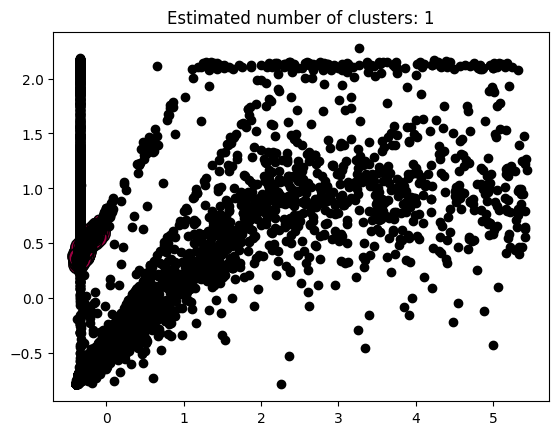

In [11]:
# Drawing chart
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = transform_result[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = transform_result[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

(array([-1,  0], dtype=int64), array([10533,   576], dtype=int64))

Text(0.5, 1.0, '')

Text(0, 0.5, 'Size of clusters')

<BarContainer object of 2 artists>

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 0, '[-1  0]')

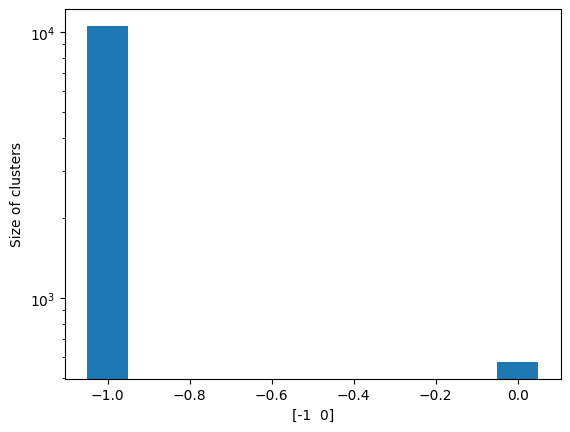

In [12]:
clusters_id, clusters_sizes

_, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel("Size of clusters")
ax.bar(x=clusters_id, height=clusters_sizes, width=0.1, log=True)
ax.set_xlabel(clusters_id)

<AxesSubplot: title={'center': 'Label composition per cluster'}, xlabel='[-1  0]'>

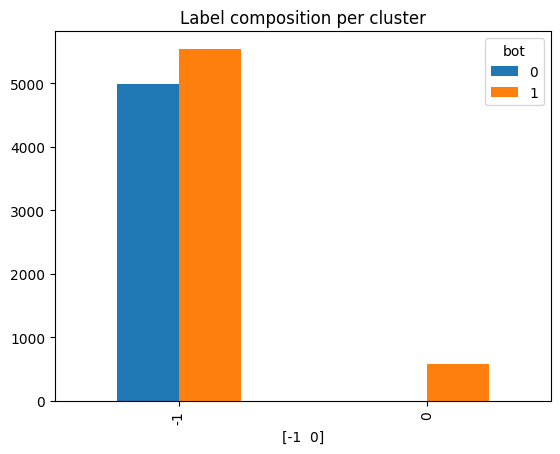

In [13]:
bot_xt_pct = pd.crosstab(labels, users_df["bot"], rownames=[str(clusters_id)])
bot_xt_pct.plot(kind= "bar", stacked= False, title= "Label composition per cluster")

## Knee Method to estimate the best eps

C:\Users\admin\AppData\Local\Temp\ipykernel_6332\2809421964.py:22: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax3.legend([data, knee_point, new_eps], ["Data", "Knee-point", "New eps radius"])


Text(0.5, 1.0, 'KNN graph with knee-point and new eps = 6.053')

Text(0, 0.5, 'dist from 30 th neighbor')

Text(0.5, 0, 'sorted distances')

(0.0, 16.053)

(10463.0, 11463.0)

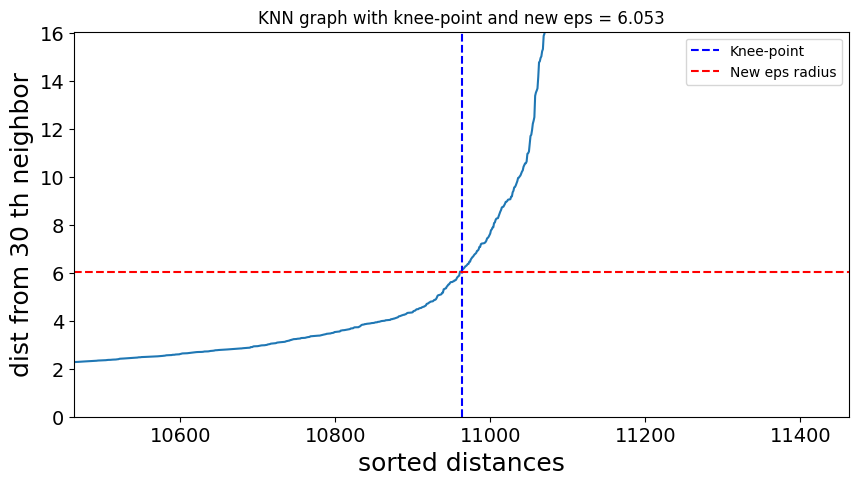

6.053


In [14]:
from kneed import KneeLocator

clusters_id, clusters_sizes = np.unique(dbscan_instance.labels_, return_counts=True)

num_of_clusters = len(clusters_id)

dist = pdist(transform_result, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist

k = initial_min_samples # k corresponds to min_points or in our case min_samples
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

kneedle = KneeLocator(range(0, len(kth_distances)), sorted(kth_distances),S= 1.0,curve= "convex",direction= "increasing")

fig3, ax3 = plt.subplots(figsize=(10, 5))
data = ax3.plot(range(0, len(kth_distances)), sorted(kth_distances))
knee_point = ax3.axvline(x = kneedle.knee, color = 'b', linestyle = '--')
new_eps = ax3.axhline(y = kneedle.knee_y, color = 'r', linestyle = '--')
ax3.legend([data, knee_point, new_eps], ["Data", "Knee-point", "New eps radius"])

ax3.set_title(label= f"KNN graph with knee-point and new eps = {round(kneedle.knee_y, 3)}")
ax3.set_ylabel('dist from %s th neighbor' % k, fontsize=18)
ax3.set_xlabel('sorted distances', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=14)
ax3.set_ylim(0 , round(kneedle.knee_y, 3) + 10)
ax3.set_xlim(round(kneedle.knee, 3) - 500, round(kneedle.knee, 3) + 500)
plt.show()
print(round(kneedle.knee_y, 3))

new_eps = round(kneedle.knee_y, 3)

Redoing DBSCAN with the new eps, and plotting results.

In [15]:
labels_true = users_df["bot"]
dbscan_instance = DBSCAN(eps=new_eps, min_samples=initial_min_samples)
dbscan_instance.fit(transform_result)

clusters_id, clusters_sizes = np.unique(dbscan_instance.labels_, return_counts=True)

core_samples_mask = np.zeros_like(dbscan_instance.labels_, dtype=bool)
core_samples_mask[dbscan_instance.core_sample_indices_] = True
labels = dbscan_instance.labels_

initial_silhuette_score = silhouette_score(transform_result, dbscan_instance.labels_)



# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(transform_result, labels))

DBSCAN(eps=6.053, min_samples=30)

Estimated number of clusters: 1
Estimated number of noise points: 74
Homogeneity: 0.000
Completeness: 0.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
Silhouette Coefficient: 0.864


Text(0.5, 1.0, 'Estimated number of clusters: 1')

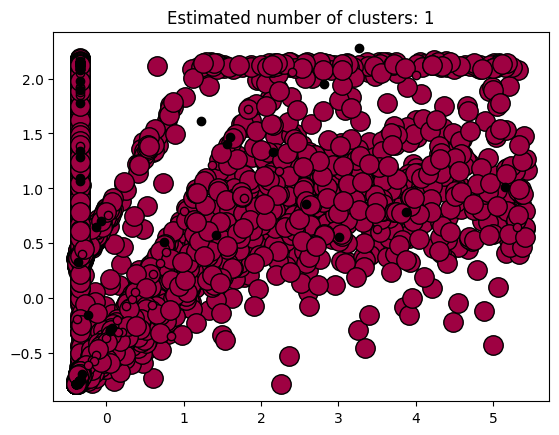

(array([-1,  0], dtype=int64), array([   74, 11035], dtype=int64))

Text(0.5, 1.0, '')

Text(0, 0.5, 'Size of clusters')

<BarContainer object of 2 artists>

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 0, '[-1  0]')

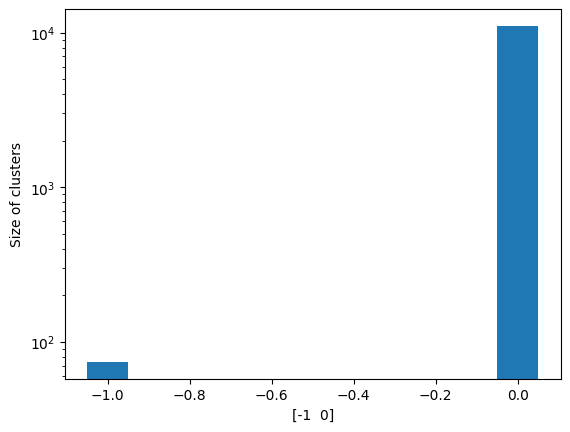

In [16]:
# Drawing chart
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = transform_result[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = transform_result[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

clusters_id, clusters_sizes

_, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel("Size of clusters")
ax.bar(x=clusters_id, height=clusters_sizes, width=0.1, log=True)#
ax.set_xlabel(clusters_id)

Observing the size of each cluster

<AxesSubplot: title={'center': 'Bots per cluster'}, xlabel='[-1  0]'>

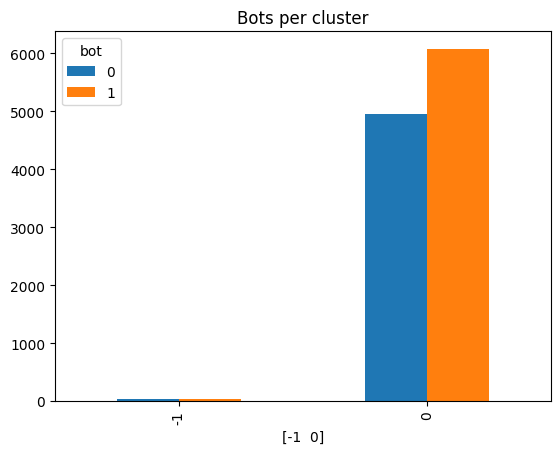

In [17]:
bot_xt_pct = pd.crosstab(labels, users_df["bot"], rownames=[str(clusters_id)])
bot_xt_pct.plot(kind= "bar", stacked= False, title= "Bots per cluster")

In [18]:
subset_df.head()

,statuses_count,number_of_tweets,avg_tweets_per_actual_day,avg_hashtags,avg_text_length,avg_mentions,total_likes,avt_favorite_count,total_replies,total_retweet_count,account_discussion_creation_ratio,tweet_num_likes_ratio,tweet_num_replies_ratio,entropy_text,mean_inactive_period_length_in_seconds
0,76,126,4.666667,0.103175,64.619048,0.285714,5,0.039683,0,5,25.200000,25.200000,0.0,1.617447e-06,1.099118e+05
1,54,116,4.640000,0.025862,70.491379,0.344828,6,0.051724,0,3,38.666667,19.333333,0.0,1.323339e-06,1.170971e+05
2,3,4,2.000000,0.000000,19.250000,0.000000,0,0.000000,0,0,0.000000,0.000000,0.0,2.029541e-07,8.816991e+06
3,50,1358,8.035503,0.081738,89.385862,0.006627,252,0.185567,0,1187,1.144061,5.388889,0.0,2.167859e-05,6.557065e+04
4,7085,3434,28.380165,0.128713,74.419045,0.526209,213,0.062027,0,60,57.233333,16.122066,0.0,2.582894e-07,8.020619e+03


# Putting it all together

Computing clusters and visualizing them with the spearman correlation tresholds of 0.1, 0.3, 0.5, 0.7, and 0.9.

StandardScaler()

array([[-0.03284551, -0.03135975],
       [-0.03283525, -0.03135975],
       [-0.03289679, -0.03135975],
       ...,
       [-0.03289679, -0.03135975],
       [-0.03280448, -0.03135975],
       [-0.02832196, -0.03135975]])

array([[  5.,   0.],
       [  6.,   0.],
       [  0.,   0.],
       ...,
       [  0.,   0.],
       [  9.,   0.],
       [446.,   0.]])

DBSCAN(eps=0.1, min_samples=4)

C:\Users\admin\AppData\Local\Temp\ipykernel_6332\3579776883.py:52: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax3.legend([data, knee_point, new_eps], ["Data", "Knee-point", "New eps radius"])


Text(0.5, 1.0, 'KNN graph with knee-point and new eps = 0.327')

Text(0, 0.5, 'dist from 4 th neighbor')

Text(0.5, 0, 'sorted distances')

(0.0, 10.327)

(10577.0, 11577.0)

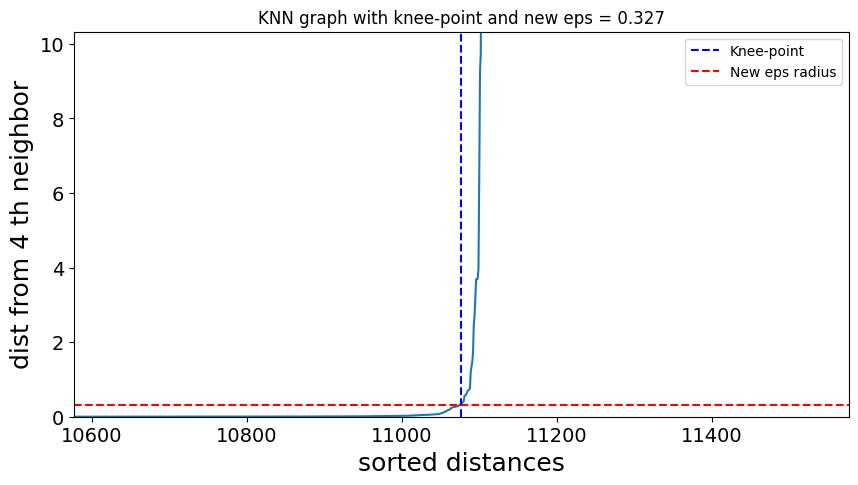

0.327


DBSCAN(eps=0.327, min_samples=4)

Text(0.5, 1.0, 'Size of clusters (spearman Coefficient < 0.1)')

Text(0, 0.5, 'Size of clusters')

<BarContainer object of 3 artists>

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 0, '[-1  0  1]')

This is the number of clusters found 3


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.1)'}, xlabel='[-1  0  1]'>

StandardScaler()

array([[-0.3306459 , -0.22887565, -0.03284551, ..., -0.17960787,
        -0.14229293, -0.13234402],
       [-0.34838232, -0.56021899, -0.03283525, ..., -0.17960855,
        -0.14229293, -0.13049436],
       [-0.38949857, -0.67105774, -0.03289679, ..., -0.17960958,
        -0.14229293,  2.10903074],
       ...,
       [-0.38707997,  0.75753055, -0.03289679, ..., -0.17960958,
        -0.14229293,  3.41425607],
       [-0.35805673, -0.62776718, -0.03280448, ..., -0.17960719,
        -0.14229293, -0.12836481],
       [ 3.86401793, -0.48013851, -0.02832196, ...,  0.47108149,
        -0.14229293, -0.15481656]])

array([[7.60000000e+01, 1.03174603e-01, 5.00000000e+00, ...,
        5.00000000e+00, 0.00000000e+00, 1.09911770e+05],
       [5.40000000e+01, 2.58620690e-02, 6.00000000e+00, ...,
        3.00000000e+00, 0.00000000e+00, 1.17097138e+05],
       [3.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 8.81699075e+06],
       ...,
       [6.00000000e+00, 3.33333333e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.38874057e+07],
       [4.20000000e+01, 1.01010101e-02, 9.00000000e+00, ...,
        7.00000000e+00, 0.00000000e+00, 1.25369798e+05],
       [5.27900000e+03, 4.45472953e-02, 4.46000000e+02, ...,
        1.90715300e+06, 0.00000000e+00, 2.26125566e+04]])

DBSCAN(eps=0.1, min_samples=16)

C:\Users\admin\AppData\Local\Temp\ipykernel_6332\3579776883.py:52: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax3.legend([data, knee_point, new_eps], ["Data", "Knee-point", "New eps radius"])


Text(0.5, 1.0, 'KNN graph with knee-point and new eps = 4.071')

Text(0, 0.5, 'dist from 16 th neighbor')

Text(0.5, 0, 'sorted distances')

(0.0, 14.071)

(10500.0, 11500.0)

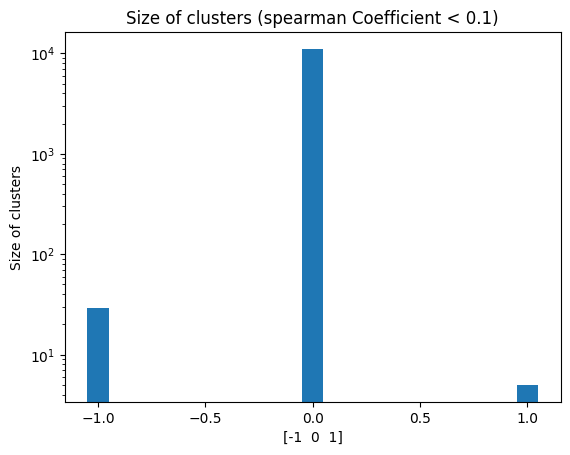

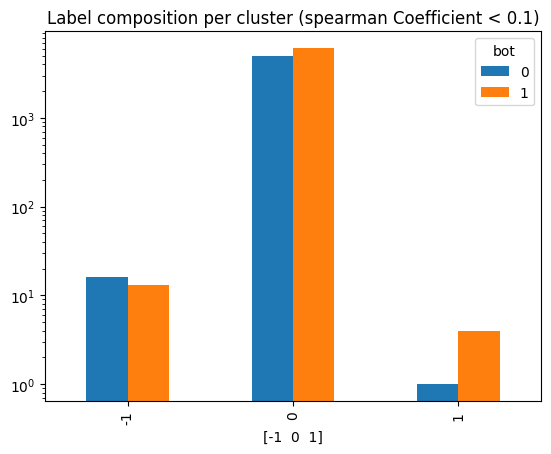

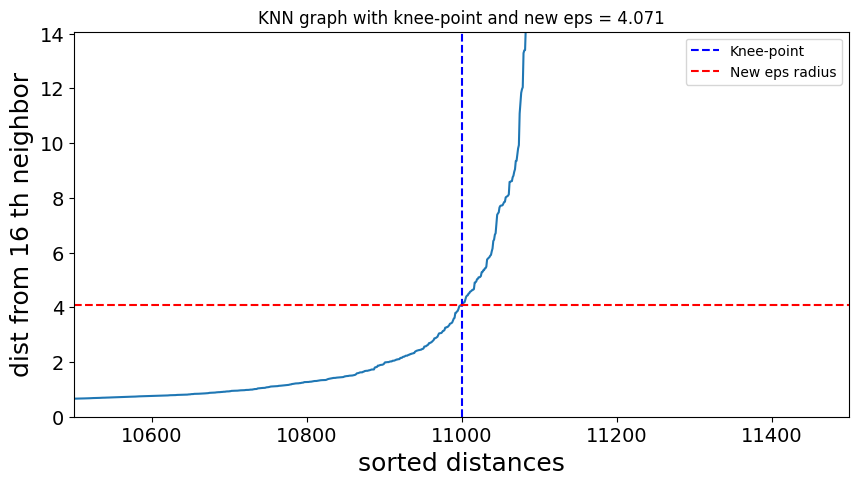

4.071


DBSCAN(eps=4.071, min_samples=16)

Text(0.5, 1.0, 'Size of clusters (spearman Coefficient < 0.3)')

Text(0, 0.5, 'Size of clusters')

<BarContainer object of 2 artists>

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 0, '[-1  0]')

This is the number of clusters found 2


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.3)'}, xlabel='[-1  0]'>

StandardScaler()

array([[-0.3306459 , -0.68008622, -0.22935888, ..., -0.14229293,
        -0.26573769, -0.13234402],
       [-0.34838232, -0.68842433, -0.23006109, ..., -0.14229293,
        -0.29303514, -0.13049436],
       [-0.38949857, -0.78181113, -0.29957988, ..., -0.14229293,
        -0.39702312,  2.10903074],
       ...,
       [-0.38707997, -0.78014351, -0.31274632, ..., -0.14229293,
        -0.40245112,  3.41425607],
       [-0.35805673, -0.70259911, -0.23889977, ..., -0.14229293,
        -0.29238634, -0.12836481],
       [ 3.86401793,  2.09733721,  1.19068249, ..., -0.14229293,
        -0.3902742 , -0.15481656]])

array([[7.60000000e+01, 1.26000000e+02, 4.66666667e+00, ...,
        0.00000000e+00, 1.61744691e-06, 1.09911770e+05],
       [5.40000000e+01, 1.16000000e+02, 4.64000000e+00, ...,
        0.00000000e+00, 1.32333930e-06, 1.17097138e+05],
       [3.00000000e+00, 4.00000000e+00, 2.00000000e+00, ...,
        0.00000000e+00, 2.02954147e-07, 8.81699075e+06],
       ...,
       [6.00000000e+00, 6.00000000e+00, 1.50000000e+00, ...,
        0.00000000e+00, 1.44471880e-07, 1.38874057e+07],
       [4.20000000e+01, 9.90000000e+01, 4.30434783e+00, ...,
        0.00000000e+00, 1.33032952e-06, 1.25369798e+05],
       [5.27900000e+03, 3.45700000e+03, 5.85932203e+01, ...,
        0.00000000e+00, 2.75668193e-07, 2.26125566e+04]])

DBSCAN(eps=0.1, min_samples=28)

C:\Users\admin\AppData\Local\Temp\ipykernel_6332\3579776883.py:52: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax3.legend([data, knee_point, new_eps], ["Data", "Knee-point", "New eps radius"])


Text(0.5, 1.0, 'KNN graph with knee-point and new eps = 4.133')

Text(0, 0.5, 'dist from 28 th neighbor')

Text(0.5, 0, 'sorted distances')

(0.0, 14.133)

(10408.0, 11408.0)

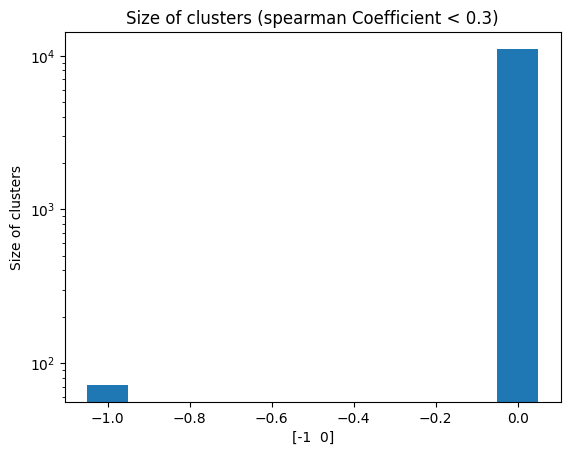

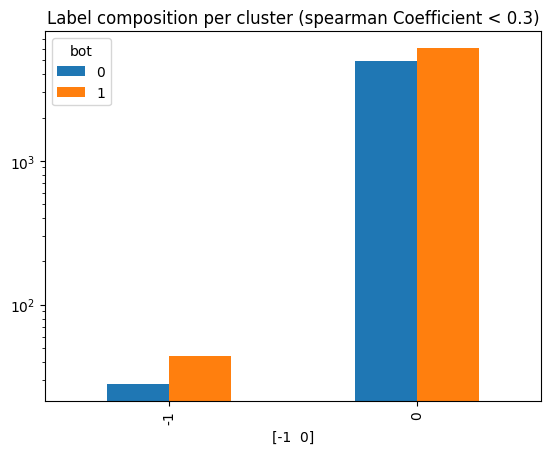

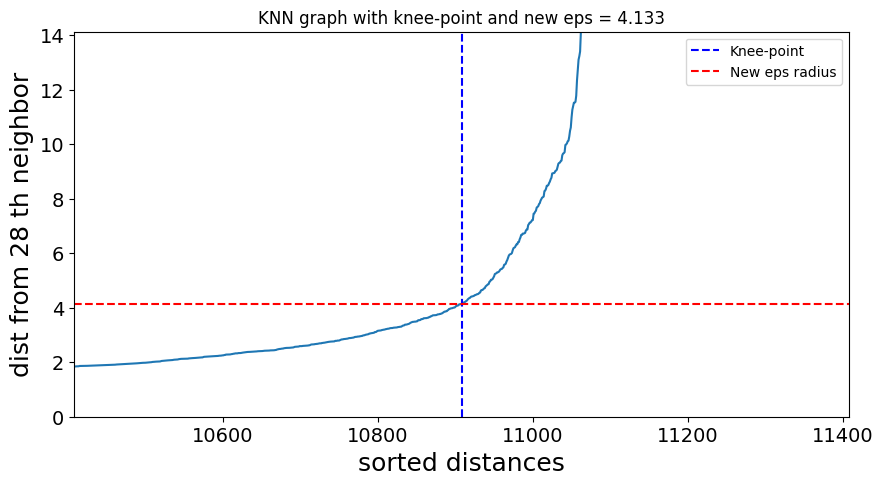

4.133


DBSCAN(eps=4.133, min_samples=28)

Text(0.5, 1.0, 'Size of clusters (spearman Coefficient < 0.5)')

Text(0, 0.5, 'Size of clusters')

<BarContainer object of 2 artists>

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 0, '[-1  0]')

This is the number of clusters found 2


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.5)'}, xlabel='[-1  0]'>

StandardScaler()

array([[-0.3306459 , -0.68008622, -0.22935888, ..., -0.14229293,
        -0.26573769, -0.13234402],
       [-0.34838232, -0.68842433, -0.23006109, ..., -0.14229293,
        -0.29303514, -0.13049436],
       [-0.38949857, -0.78181113, -0.29957988, ..., -0.14229293,
        -0.39702312,  2.10903074],
       ...,
       [-0.38707997, -0.78014351, -0.31274632, ..., -0.14229293,
        -0.40245112,  3.41425607],
       [-0.35805673, -0.70259911, -0.23889977, ..., -0.14229293,
        -0.29238634, -0.12836481],
       [ 3.86401793,  2.09733721,  1.19068249, ..., -0.14229293,
        -0.3902742 , -0.15481656]])

array([[7.60000000e+01, 1.26000000e+02, 4.66666667e+00, ...,
        0.00000000e+00, 1.61744691e-06, 1.09911770e+05],
       [5.40000000e+01, 1.16000000e+02, 4.64000000e+00, ...,
        0.00000000e+00, 1.32333930e-06, 1.17097138e+05],
       [3.00000000e+00, 4.00000000e+00, 2.00000000e+00, ...,
        0.00000000e+00, 2.02954147e-07, 8.81699075e+06],
       ...,
       [6.00000000e+00, 6.00000000e+00, 1.50000000e+00, ...,
        0.00000000e+00, 1.44471880e-07, 1.38874057e+07],
       [4.20000000e+01, 9.90000000e+01, 4.30434783e+00, ...,
        0.00000000e+00, 1.33032952e-06, 1.25369798e+05],
       [5.27900000e+03, 3.45700000e+03, 5.85932203e+01, ...,
        0.00000000e+00, 2.75668193e-07, 2.26125566e+04]])

DBSCAN(eps=0.1, min_samples=30)

C:\Users\admin\AppData\Local\Temp\ipykernel_6332\3579776883.py:52: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax3.legend([data, knee_point, new_eps], ["Data", "Knee-point", "New eps radius"])


Text(0.5, 1.0, 'KNN graph with knee-point and new eps = 6.053')

Text(0, 0.5, 'dist from 30 th neighbor')

Text(0.5, 0, 'sorted distances')

(0.0, 16.053)

(10463.0, 11463.0)

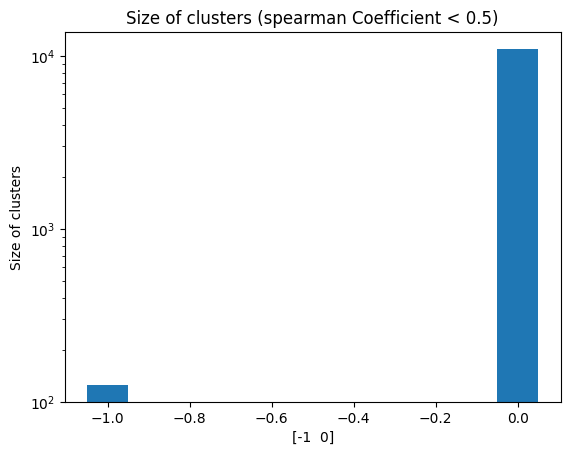

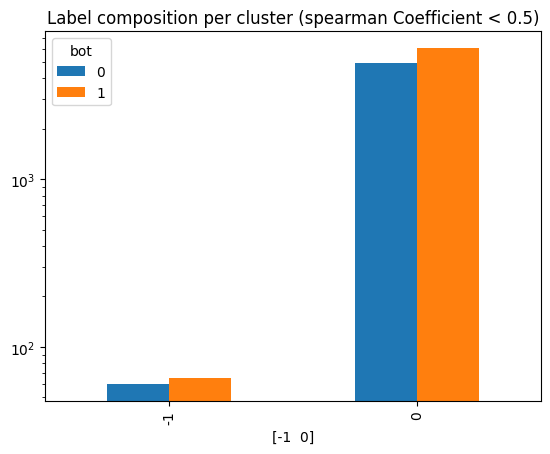

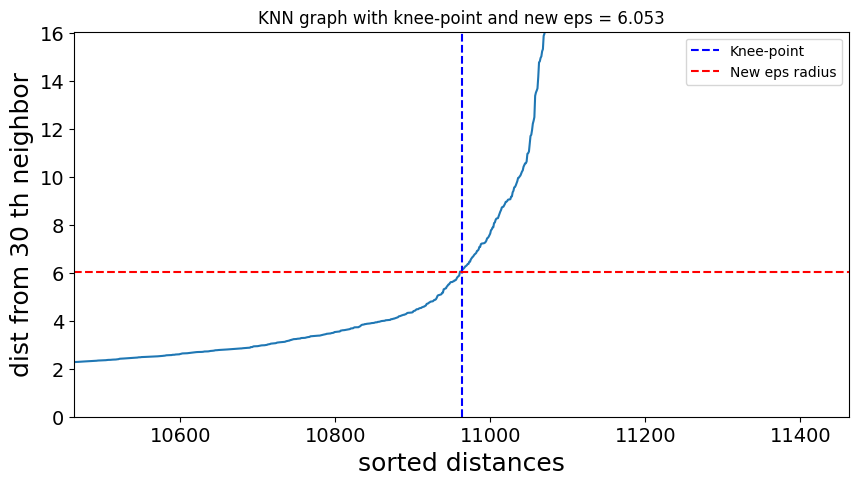

6.053


DBSCAN(eps=6.053, min_samples=30)

Text(0.5, 1.0, 'Size of clusters (spearman Coefficient < 0.7)')

Text(0, 0.5, 'Size of clusters')

<BarContainer object of 2 artists>

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 0, '[-1  0]')

This is the number of clusters found 2


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.7)'}, xlabel='[-1  0]'>

StandardScaler()

array([[-0.3306459 , -0.68008622, -0.22935888, ..., -0.13234402,
        -0.05121961, -0.56140343],
       [-0.34838232, -0.68842433, -0.23006109, ..., -0.13049436,
        -0.05121961, -0.52796646],
       [-0.38949857, -0.78181113, -0.29957988, ...,  2.10903074,
        -0.05121961, -0.61991814],
       ...,
       [-0.38707997, -0.78014351, -0.31274632, ...,  3.41425607,
        -0.05120817, -0.61991814],
       [-0.35805673, -0.70259911, -0.23889977, ..., -0.12836481,
        -0.05121961, -0.56140343],
       [ 3.86401793,  2.09733721,  1.19068249, ..., -0.15481656,
        -0.05121961,  1.72066996]])

array([[7.60000000e+01, 1.26000000e+02, 4.66666667e+00, ...,
        1.09911770e+05, 0.00000000e+00, 8.00000000e+00],
       [5.40000000e+01, 1.16000000e+02, 4.64000000e+00, ...,
        1.17097138e+05, 0.00000000e+00, 1.20000000e+01],
       [3.00000000e+00, 4.00000000e+00, 2.00000000e+00, ...,
        8.81699075e+06, 0.00000000e+00, 1.00000000e+00],
       ...,
       [6.00000000e+00, 6.00000000e+00, 1.50000000e+00, ...,
        1.38874057e+07, 3.70000000e+01, 1.00000000e+00],
       [4.20000000e+01, 9.90000000e+01, 4.30434783e+00, ...,
        1.25369798e+05, 0.00000000e+00, 8.00000000e+00],
       [5.27900000e+03, 3.45700000e+03, 5.85932203e+01, ...,
        2.26125566e+04, 0.00000000e+00, 2.81000000e+02]])

DBSCAN(eps=0.1, min_samples=48)

C:\Users\admin\AppData\Local\Temp\ipykernel_6332\3579776883.py:52: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax3.legend([data, knee_point, new_eps], ["Data", "Knee-point", "New eps radius"])


Text(0.5, 1.0, 'KNN graph with knee-point and new eps = 9.764')

Text(0, 0.5, 'dist from 48 th neighbor')

Text(0.5, 0, 'sorted distances')

(0.0, 19.764)

(10482.0, 11482.0)

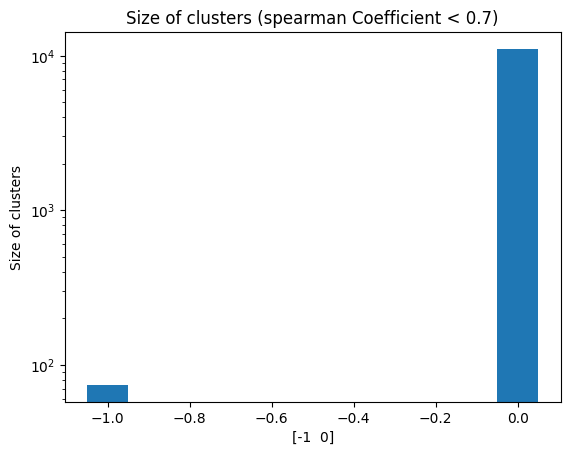

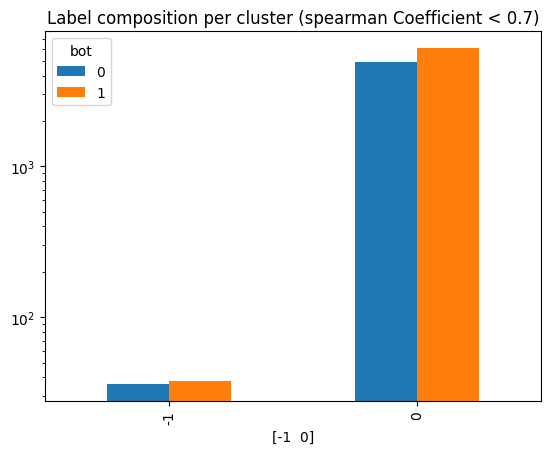

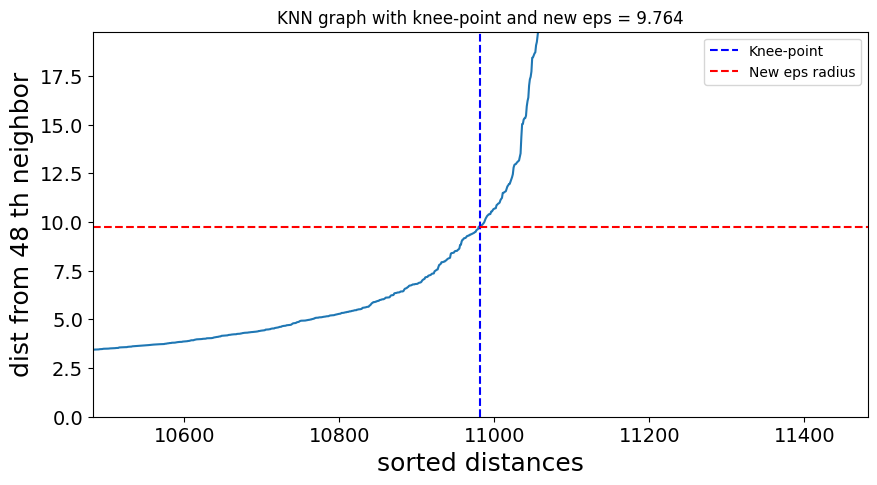

9.764


DBSCAN(eps=9.764, min_samples=48)

Text(0.5, 1.0, 'Size of clusters (spearman Coefficient < 0.9)')

Text(0, 0.5, 'Size of clusters')

<BarContainer object of 2 artists>

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 0, '[-1  0]')

This is the number of clusters found 2


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.9)'}, xlabel='[-1  0]'>

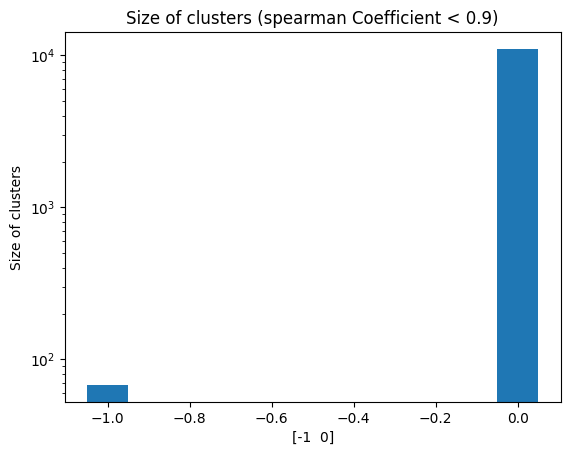

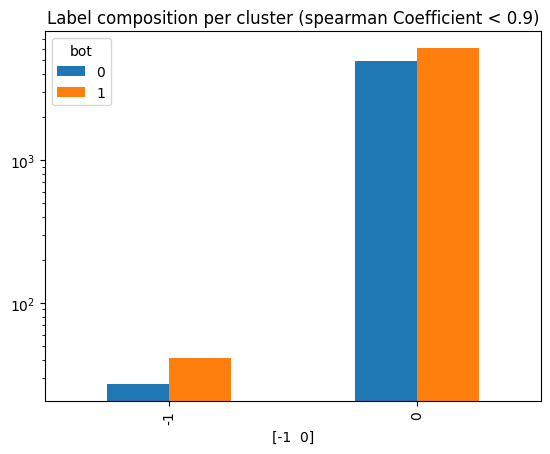

In [19]:
labels_true = users_df["bot"]

correlation_method = "spearman"

thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
metrics_df = pd.DataFrame(
    [
        [None, None, None, None, None, None, None, None, None, None, None, None]
        for threshold in thresholds
    ],
    index= [threshold for threshold in thresholds],
    columns=[ "new eps", "minimum number of samples", "number of dimensions", "number of clusters", "number of noise points", "Homogeneity", "Completeness", "V-measure", "Adjusted Rand Index", "Adjusted Mutual Information","Silhouette", "Davies Bouldin", ]
)

scaler = StandardScaler()

for threshold in thresholds:
    correlation_treshold = threshold
    subset_df = apply_correlation_threshold(users_df, correlation_method, correlation_treshold)
    subset_df.drop(columns=["user_id", "bot"], inplace=True, errors='ignore')

    scaler.fit(subset_df.values)
    scaler.transform(subset_df.values)
    scaler.inverse_transform(scaler.transform(subset_df.values))
    transform_result = scaler.fit_transform(subset_df.values)
    # Define initial DBSCAN parameters
    initial_min_samples = len(subset_df.columns)*2
    initial_eps = eps=0.10
    # 
    dbscan_instance = DBSCAN(eps=initial_eps, min_samples=initial_min_samples)
    dbscan_instance.fit(transform_result)

    clusters_id, clusters_sizes = np.unique(dbscan_instance.labels_, return_counts=True)
    # Finding best eps value with the knee method
    num_of_clusters = len(clusters_id)

    dist = pdist(transform_result, 'euclidean') #pair wise distance
    dist = squareform(dist) #distance matrix given the vector dist

    k = initial_min_samples # k corresponds to min_points or in our case min_samples
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    kneedle = KneeLocator(range(0, len(kth_distances)), sorted(kth_distances),S= 1.0,curve= "convex",direction= "increasing")

    fig3, ax3 = plt.subplots(figsize=(10, 5))
    data = ax3.plot(range(0, len(kth_distances)), sorted(kth_distances))
    knee_point = ax3.axvline(x = kneedle.knee, color = 'b', linestyle = '--')
    new_eps = ax3.axhline(y = kneedle.knee_y, color = 'r', linestyle = '--')
    ax3.legend([data, knee_point, new_eps], ["Data", "Knee-point", "New eps radius"])

    ax3.set_title(label= f"KNN graph with knee-point and new eps = {round(kneedle.knee_y, 3)}")
    ax3.set_ylabel('dist from %s th neighbor' % k, fontsize=18)
    ax3.set_xlabel('sorted distances', fontsize=18)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    ax3.set_ylim(0 , round(kneedle.knee_y, 3) + 10)
    ax3.set_xlim(round(kneedle.knee, 3) - 500, round(kneedle.knee, 3) + 500)
    plt.show()
    print(round(kneedle.knee_y, 3))

    new_eps = round(kneedle.knee_y, 3)
    # Redoing the DBSCAN clustering with the new eps parameter
    dbscan_instance = DBSCAN(eps=new_eps, min_samples=initial_min_samples)
    dbscan_instance.fit(transform_result)
    clusters_id, clusters_sizes = np.unique(dbscan_instance.labels_, return_counts=True)
    labels = dbscan_instance.labels_
    # Plotting results - Clusters
    _, ax = plt.subplots()
    ax.set_title(f"Size of clusters ({correlation_method} Coefficient < {threshold})")
    ax.set_ylabel("Size of clusters")
    ax.bar(x=clusters_id, height=clusters_sizes, width=0.1, log=True)
    ax.set_xlabel(clusters_id)
    print(f"This is the number of clusters found {len(clusters_id)}")
    # Plotting results - Cluster composition
    bot_xt_pct = pd.crosstab(labels, users_df["bot"], rownames=[str(clusters_id)])
    bot_xt_pct.plot(kind= "bar", stacked= False, logy= True, title= f"Label composition per cluster ({correlation_method} Coefficient < {threshold})")


    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    # get cluster metrics
    metrics_df.loc[threshold]["new eps"] = new_eps
    metrics_df.loc[threshold]["minimum number of samples"] = initial_min_samples
    metrics_df.loc[threshold]["number of dimensions"] = len(subset_df.columns)
    metrics_df.loc[threshold]["number of clusters"] = n_clusters_
    metrics_df.loc[threshold]["number of noise points"] = n_noise_
    metrics_df.loc[threshold]["Homogeneity"] = metrics.homogeneity_score(labels_true, labels)
    metrics_df.loc[threshold]["Completeness"] = metrics.completeness_score(labels_true, labels)
    metrics_df.loc[threshold]["V-measure"] = metrics.v_measure_score(labels_true, labels)
    metrics_df.loc[threshold]["Adjusted Rand Index"] = metrics.adjusted_rand_score(labels_true, labels)
    metrics_df.loc[threshold]["Adjusted Mutual Information"] = metrics.adjusted_mutual_info_score(labels_true, labels)
    metrics_df.loc[threshold]["Silhouette"] = metrics.silhouette_score(transform_result, labels)
    metrics_df.loc[threshold]["Davies Bouldin"] = metrics.davies_bouldin_score(transform_result, labels)


In [29]:
#import dataframe_image as dfi
#dfi.export(metrics_df, "metrics_table.png")
metrics_df

,new eps,minimum number of samples,number of dimensions,number of clusters,number of noise points,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information,Silhouette,Davies Bouldin
0.1,0.327,4,2,2,29,0.000169,0.005283,0.000328,0.000125,0.000051,0.992574,1.546842
0.3,4.071,16,8,1,72,0.000071,0.00125,0.000134,-0.000316,0.00001,0.918742,2.161237
0.5,4.133,28,14,1,125,0.000031,0.000347,0.000057,0.000272,-0.000064,0.839102,2.808818
0.7,6.053,30,15,1,74,0.000027,0.000462,0.000051,0.000197,-0.000074,0.863667,2.698189
0.9,9.764,48,24,1,68,0.00005,0.000924,0.000095,-0.000259,-0.00003,0.851016,2.632555


## DMDBSCAN Clustering
Dynamic Method DBSCAN
According to Elbatta & Ashour 2013 "It selects several values of the radius of a number of objects (Eps) for different densities according to a k-dist plot. For each value of Eps, DBSCAN algorithm is adopted in order to make sure that all the clusters with respect to the corresponding density are clustered. For the next process, the points that have been clustered are ignored, which avoids marking both denser areas and sparser ones as one cluster."
Source: https://www.researchgate.net/publication/256706346_A_dynamic_Method_for_Discovering_Density_Varied_Clusters

In this way, eps is chosen automatically, and is a parameter that we no longer have to set ourselves. Thus only the optimal number for min_samples will have to be found.

Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.

**eps:**
According to this article: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf
The optimal size of eps can be found by 

**Defining min_samples:**
According to this article: https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd#:~:text=Generally%2C%20MinPts%20should%20be%20greater,et%20al.%2C%201998).
min_samples should be defined as greater or equal to the number of dimensions times 2.
I will start with this min_samples size and work my way up from there.

Estimated number of clusters: 3
Estimated number of noise points: 10254
Homogeneity: 0.071
Completeness: 0.159
V-measure: 0.098
Adjusted Rand Index: -0.007
Adjusted Mutual Information: 0.098
Silhouette Coefficient: 0.080
Davies Bouldin Coefficient: 0.868


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.7)'}, xlabel='[-1  0  1  2]'>

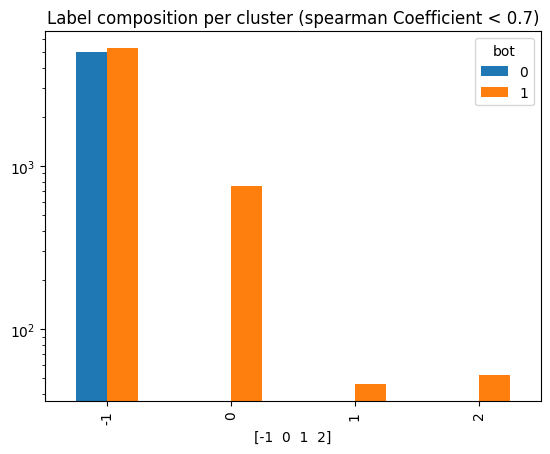

In [22]:
from sklearn.cluster import OPTICS

correlation_treshold = 0.7
subset_df = apply_correlation_threshold(users_df, correlation_method, correlation_treshold)
subset_df.drop(columns=["user_id", "bot"], inplace=True, errors='ignore')

scaler = StandardScaler()
transform_result = scaler.fit_transform(subset_df.values)

initial_min_samples = len(subset_df.columns)*2

optics_instance = OPTICS(min_samples=initial_min_samples).fit(transform_result)

clusters_id, clusters_sizes = np.unique(optics_instance.labels_, return_counts=True)
labels = optics_instance.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(transform_result, labels))
print("Davies Bouldin Coefficient: %0.3f" % metrics.davies_bouldin_score(transform_result, labels))

# Plotting results - Cluster composition
bot_xt_pct = pd.crosstab(labels, users_df["bot"], rownames=[str(clusters_id)])
bot_xt_pct.plot(kind= "bar", stacked= False, logy= True, title= f"Label composition per cluster ({correlation_method} Coefficient < {correlation_treshold})")

Estimated number of clusters: 2
Estimated number of noise points: 9901
Homogeneity: 0.102
Completeness: 0.171
V-measure: 0.128
Adjusted Rand Index: -0.003
Adjusted Mutual Information: 0.128
Silhouette Coefficient: 0.168
Davies Bouldin Coefficient: 0.865


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.7)'}, xlabel='[-1  0  1]'>

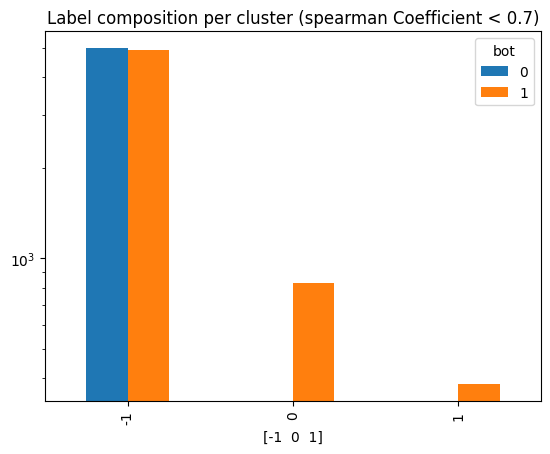

In [23]:
from sklearn.cluster import OPTICS

correlation_treshold = 0.7
subset_df = apply_correlation_threshold(users_df, correlation_method, correlation_treshold)
subset_df.drop(columns=["user_id", "bot"], inplace=True, errors='ignore')

scaler = StandardScaler()
transform_result = scaler.fit_transform(subset_df.values)

initial_min_samples = len(subset_df.columns)*4

optics_instance = OPTICS(min_samples=initial_min_samples).fit(transform_result)

clusters_id, clusters_sizes = np.unique(optics_instance.labels_, return_counts=True)
labels = optics_instance.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(transform_result, labels))
print("Davies Bouldin Coefficient: %0.3f" % metrics.davies_bouldin_score(transform_result, labels))

# Plotting results - Cluster composition
bot_xt_pct = pd.crosstab(labels, users_df["bot"], rownames=[str(clusters_id)])
bot_xt_pct.plot(kind= "bar", stacked= False, logy= True, title= f"Label composition per cluster ({correlation_method} Coefficient < {correlation_treshold})")

Estimated number of clusters: 2
Estimated number of noise points: 9929
Homogeneity: 0.100
Completeness: 0.170
V-measure: 0.126
Adjusted Rand Index: -0.003
Adjusted Mutual Information: 0.126
Silhouette Coefficient: 0.163
Davies Bouldin Coefficient: 0.870


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.7)'}, xlabel='[-1  0  1]'>

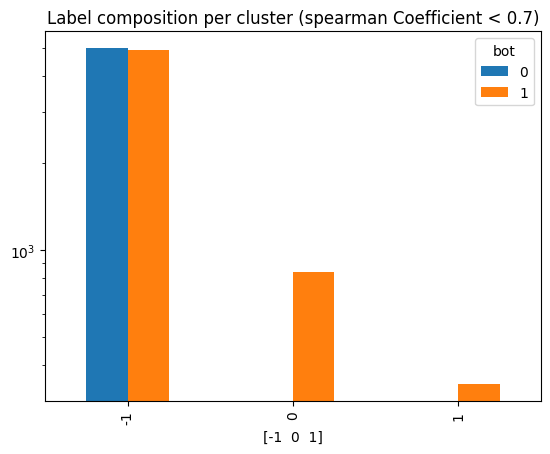

In [24]:
from sklearn.cluster import OPTICS

correlation_treshold = 0.7
subset_df = apply_correlation_threshold(users_df, correlation_method, correlation_treshold)
subset_df.drop(columns=["user_id", "bot"], inplace=True, errors='ignore')

scaler = StandardScaler()
transform_result = scaler.fit_transform(subset_df.values)

initial_min_samples = len(subset_df.columns)*20

optics_instance = OPTICS(min_samples=initial_min_samples).fit(transform_result)

clusters_id, clusters_sizes = np.unique(optics_instance.labels_, return_counts=True)
labels = optics_instance.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(transform_result, labels))
print("Davies Bouldin Coefficient: %0.3f" % metrics.davies_bouldin_score(transform_result, labels))

# Plotting results - Cluster composition
bot_xt_pct = pd.crosstab(labels, users_df["bot"], rownames=[str(clusters_id)])
bot_xt_pct.plot(kind= "bar", stacked= False, logy= True, title= f"Label composition per cluster ({correlation_method} Coefficient < {correlation_treshold})")

c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_optics.py:903: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Estimated number of clusters: 573
Estimated number of noise points: 1435
Homogeneity: 0.177
Completeness: 0.026
V-measure: 0.045
Adjusted Rand Index: 0.010
Adjusted Mutual Information: 0.035
Silhouette Coefficient: 0.689
Davies Bouldin Coefficient: 2.268


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.1)'}, xlabel='[ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16\n  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34\n  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52\n  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70\n  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88\n  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106\n 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124\n 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142\n 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160\n 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178\n 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196\n 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214\n 215 216 2

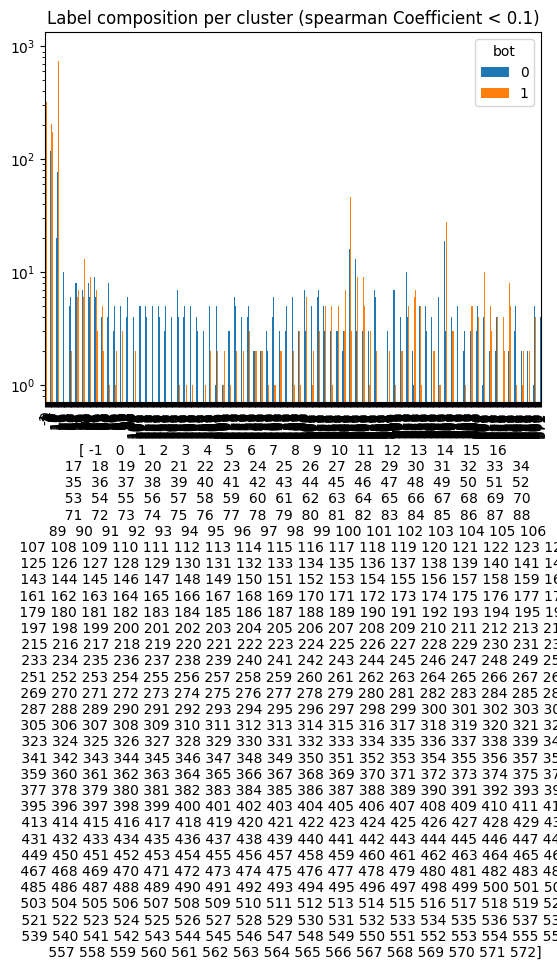

In [25]:
from sklearn.cluster import OPTICS

correlation_treshold = 0.1
subset_df = apply_correlation_threshold(users_df, correlation_method, correlation_treshold)
subset_df.drop(columns=["user_id", "bot"], inplace=True, errors='ignore')

scaler = StandardScaler()
transform_result = scaler.fit_transform(subset_df.values)

initial_min_samples = len(subset_df.columns)*2

optics_instance = OPTICS(min_samples=initial_min_samples).fit(transform_result)

clusters_id, clusters_sizes = np.unique(optics_instance.labels_, return_counts=True)
labels = optics_instance.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(transform_result, labels))
print("Davies Bouldin Coefficient: %0.3f" % metrics.davies_bouldin_score(transform_result, labels))

# Plotting results - Cluster composition
bot_xt_pct = pd.crosstab(labels, users_df["bot"], rownames=[str(clusters_id)])
bot_xt_pct.plot(kind= "bar", stacked= False, logy= True, title= f"Label composition per cluster ({correlation_method} Coefficient < {correlation_treshold})")

Estimated number of clusters: 64
Estimated number of noise points: 9283
Homogeneity: 0.054
Completeness: 0.033
V-measure: 0.041
Adjusted Rand Index: -0.010
Adjusted Mutual Information: 0.038
Silhouette Coefficient: -0.592
Davies Bouldin Coefficient: 1.793


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.3)'}, xlabel='[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22\n 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46\n 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]'>

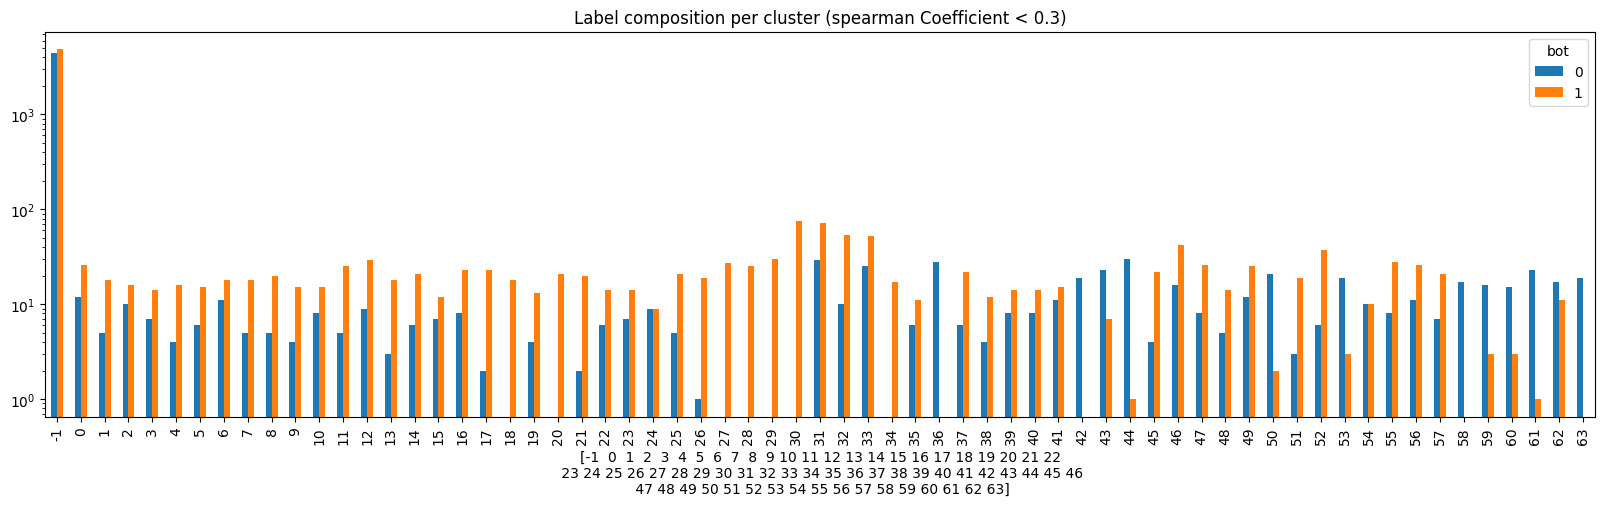

In [30]:
from sklearn.cluster import OPTICS

correlation_treshold = 0.3
subset_df = apply_correlation_threshold(users_df, correlation_method, correlation_treshold)
subset_df.drop(columns=["user_id", "bot"], inplace=True, errors='ignore')

scaler = StandardScaler()
transform_result = scaler.fit_transform(subset_df.values)

initial_min_samples = len(subset_df.columns)*2

optics_instance = OPTICS(min_samples=initial_min_samples).fit(transform_result)

clusters_id, clusters_sizes = np.unique(optics_instance.labels_, return_counts=True)
labels = optics_instance.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(transform_result, labels))
print("Davies Bouldin Coefficient: %0.3f" % metrics.davies_bouldin_score(transform_result, labels))

# Plotting results - Cluster composition
bot_xt_pct = pd.crosstab(labels, users_df["bot"], rownames=[str(clusters_id)])
bot_xt_pct.plot(kind= "bar", stacked= False, logy= True, title= f"Label composition per cluster ({correlation_method} Coefficient < {correlation_treshold})", figsize=(20,5))

Estimated number of clusters: 3
Estimated number of noise points: 10254
Homogeneity: 0.071
Completeness: 0.159
V-measure: 0.098
Adjusted Rand Index: -0.007
Adjusted Mutual Information: 0.098
Silhouette Coefficient: 0.093
Davies Bouldin Coefficient: 0.861


<AxesSubplot: title={'center': 'Label composition per cluster (spearman Coefficient < 0.5)'}, xlabel='[-1  0  1  2]'>

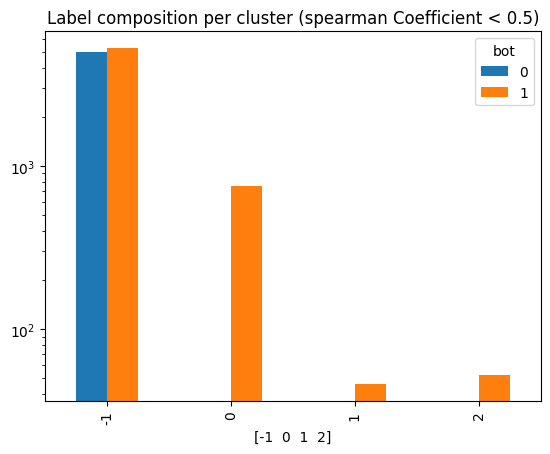

In [27]:
from sklearn.cluster import OPTICS

correlation_treshold = 0.5
subset_df = apply_correlation_threshold(users_df, correlation_method, correlation_treshold)
subset_df.drop(columns=["user_id", "bot"], inplace=True, errors='ignore')

scaler = StandardScaler()
transform_result = scaler.fit_transform(subset_df.values)

initial_min_samples = len(subset_df.columns)*2

optics_instance = OPTICS(min_samples=initial_min_samples).fit(transform_result)

clusters_id, clusters_sizes = np.unique(optics_instance.labels_, return_counts=True)
labels = optics_instance.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(transform_result, labels))
print("Davies Bouldin Coefficient: %0.3f" % metrics.davies_bouldin_score(transform_result, labels))

# Plotting results - Cluster composition
bot_xt_pct = pd.crosstab(labels, users_df["bot"], rownames=[str(clusters_id)])
bot_xt_pct.plot(kind= "bar", stacked= False, logy= True, title= f"Label composition per cluster ({correlation_method} Coefficient < {correlation_treshold})")